# Import statements

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import random
from IPython.display import display, clear_output, update_display
import bayes_opt

from pmd_beamphysics import ParticleGroup
#from pmd_beamphysics.statistics import resample_particles
import pmd_beamphysics.statistics

from UTILITY_plotNMM import plotNMM, slicePlotNMM
from UTILITY_linacPhaseAndAmplitude import getLinacMatchStrings, setLinacPhase, setLinacGradientAuto
from UTILITY_modifyAndSaveInputBeam import modifyAndSaveInputBeam
from UTILITY_setLattice import setLattice, getBendkG, getQuadkG, getSextkG

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao


# Start tao

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 

#Need to explicitly add non-MARKER places to save beam...
tao.cmd("set beam add_saved_at = DTOTR, XTCAVF, M2EX")

#Use dump_file
tao.cmd('set beam dump_file = "tao_dump.h5"')
#tao.cmd('set beam dump_at = "E*D*"')
tao.cmd('set beam dump_at = "*"')
        

[]

# Plot single particle twiss

In [7]:
#Helper functions for single particle Twiss plots

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches
    
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 

In [8]:
elements=tao.lat_ele_list();

floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True);

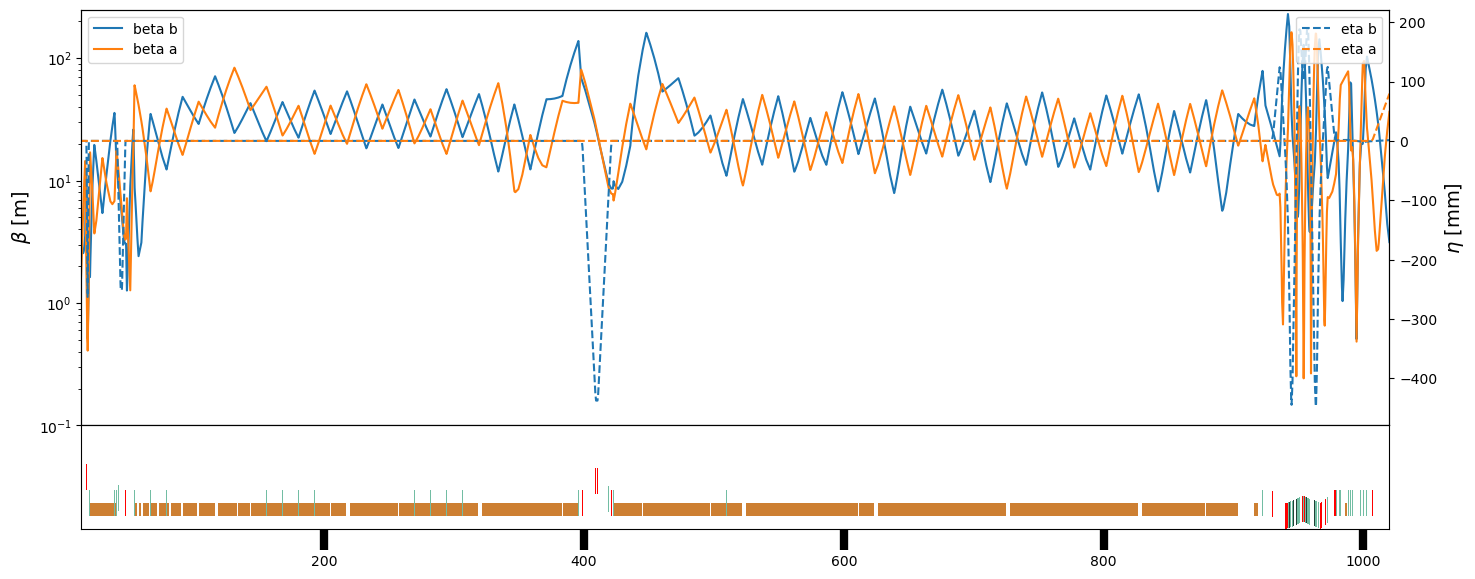

In [9]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']




#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

# Beam construction

## Import beam

In [3]:
lastTrackedElement = "end"
tao.cmd(f'set beam_init track_end = {lastTrackedElement}')
#Can see present track_start and track_end values with `show beam`


#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
tao.cmd('csron')
#tao.cmd('csroff')

[]

In [4]:
inputBeamFilePath = f'{filePath}/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5'


modifyAndSaveInputBeam(
    inputBeamFilePath,
#    numMacroParticles = 10000
)

tao.cmd(f'set beam_init position_file={filePath}/beams/activeBeamFile.h5')
tao.cmd('reinit beam')

#Set lattice to my latest default config
setLattice(tao)

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

[]

In [8]:
PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))

sigmaX = PPENT.std("x")
sigmaY = PPENT.std("y")
sigmaZ = PPENT.std("t")*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z

print(f"{sigmaX}, {sigmaY}, {sigmaZ}")

# display(plotNMM(PPENT, 'x', 'y',  bins=300))
# display(plotNMM(PPENT, 'x', 'pz', bins=300))
# display(plotNMM(PPENT, 'x', 'px', bins=300))
# display(plotNMM(PPENT, 'y', 'py', bins=300))
# display(plotNMM(PPENT, 'delta_t', 'pz', bins=300))
# display(slicePlotNMM(PPENT, 'norm_emit_x',n_slice=100))

0.00024817133406181526, 3.4573506574537854e-05, 7.936343439102645e-05


# Phase scan

In [9]:
allElementsData = [[tao.lat_list(key, att) for att in ["ele.name","ele.key","ele.s"]] for key in tao.lat_ele_list()]
markerElementsData = [row for row in allElementsData if row[1] == ['Marker']]

#Clean up formatting
markerElementsData = [[row[0][0],row[1][0],row[2][0]] for row in markerElementsData]

In [10]:
inputBeamFilePath = f'{filePath}/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5'


modifyAndSaveInputBeam(
    inputBeamFilePath,
    numMacroParticles = 10000
)

tao.cmd(f'set beam_init position_file={filePath}/beams/activeBeamFile.h5')
tao.cmd('reinit beam')

[]

In [11]:
# selectMarkers  = np.array([
#     #"ENDDL10", 
#     "BEGBC11_1", 
#     "BC11CEND", 
#     "BEGBC14_1", 
#     "ENDBC14_2", 
#     "BEGBC20", 
#     "ENDBC20", 
#     #"PENT"
# ])


In [12]:
setLattice(
    tao,
    L1PhaseSet = -15,
    L2PhaseSet = -40 
)

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

#for markerString in selectMarkers[1:-1:10]:
for row in markerElementsData[9:-1:1]: #Skip first few elements where GPT is used
    [markerString, markerType, markerS] = row
    
    P = ParticleGroup(data=tao.bunch_data(markerString))
    P = P[P.status==1]

    
    print(f"""{markerString} Mean_E: {P["mean_energy"]/1e9}""")
    
    P.z = 3e8 * P["delta_t"] #Beware! Making this change makes this ParticleGroup non-self-consistent. Watch sign and consider setting P.t = 0
    
    
    #display(plotNMM(P, 'delta_t', 'pz', bins=100))
    #display(plotNMM(P, 'z', 'pz', bins=100))

    #P.write(f"/Users/nmajik/tmpSLACData/{markerString}_{markerS}.h5")

OUTCPBF Mean_E: 0.12382606658188622
L0BFEND Mean_E: 0.12499494039190455
L0BFWAKE Mean_E: 0.12499494039190455
FLNGBF2 Mean_E: 0.12499494039190455
ENDINJ Mean_E: 0.12499494039190455
BEGDL10 Mean_E: 0.12499494039190455
IM10431 Mean_E: 0.12499494039190455
LH10BEG Mean_E: 0.12499494039190455
HTRUNDF Mean_E: 0.12499494040057454
LH10END Mean_E: 0.12499494041458853
WS10561 Mean_E: 0.12499494041458895
MRK0F Mean_E: 0.12499494041458895
IM10591 Mean_E: 0.12499494041458895
BX0FBEG Mean_E: 0.12499494041458895
CNT0F Mean_E: 0.12499494040568382
BX0FEND Mean_E: 0.12499494040568382
IM10791 Mean_E: 0.1249949404056845
ENDDL10 Mean_E: 0.1249949404056845
BEGL1F Mean_E: 0.1249949404056845
L1XFEND Mean_E: 0.3321157935437298
ENDL1F Mean_E: 0.3321157935437298
BEGBC11_1 Mean_E: 0.3321157935437298
BC11CBEG Mean_E: 0.33211579354373927
CNT1B Mean_E: 0.33211579313095063
BC11CEND Mean_E: 0.33211579313095063
ENDBC11_1 Mean_E: 0.33211579313095063
BEGBC11_2 Mean_E: 0.33211579313095063
IM11360 Mean_E: 0.3321157931309509